# Data preparation

In [ ]:
import pandas as pd

In [ ]:
# import data, skiprows=1 karena data di csv mulai dari baris ke-2
dataset = pd.read_csv("Dataset-PT.csv",skiprows=1)

Some features are dropped because they are irrelevant to solving the task.
Calender date is irrelevant because we only have data for 1/2 of a year. The dates are thereby not reoccurent and can not be used to predict the arrival delay. Weather, temperature, day-of-week and time-of-day are also dropped because they are already represented in the dataset as factors (0-1)

In [ ]:
df = dataset.drop(['Calendar_date', 'weather', 'temperature', 'day_of_week','time_of_day' ], axis=1)

In [ ]:
corr_matrix = df.corr()
corr_matrix['arrival_delay'].sort_values(ascending=False)

,arrival_delay
arrival_delay,1.000000
upstream_stop_delay,0.975019
origin_delay,0.716324
previous_bus_delay,0.265434
factor(day_of_week)weekend,0.190783
factor(time_of_day)Off-peak,0.138109
stop_sequence,0.092616
dwell_time,0.089433
travel_time_for_previous_section,0.081113
factor(weather)Normal,0.022642


**A scatterplot of arrival delay and origin delay to search for outliers**

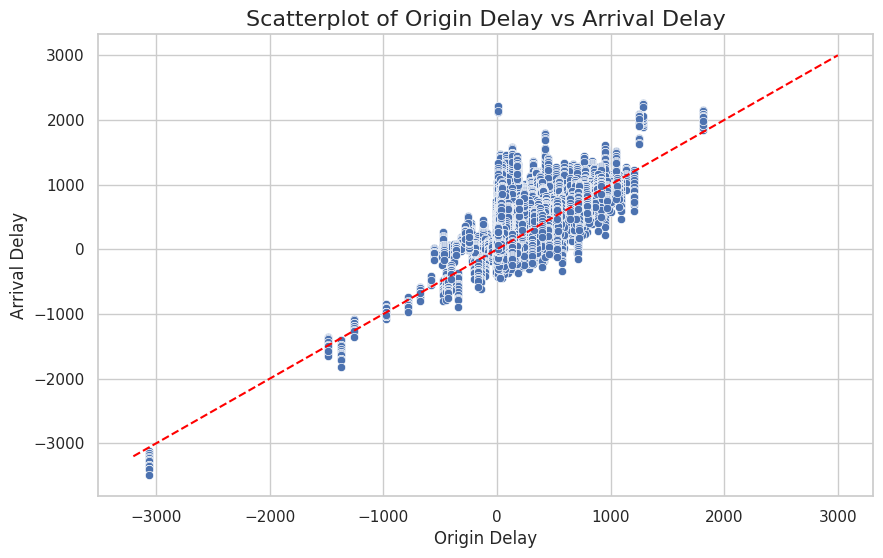

In [ ]:
# scatterplot
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style for the plot
sns.set(style="whitegrid")

# Create a scatterplot of 'origin_delay' vs 'arrival_delay'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='origin_delay', y='arrival_delay', data=df)

# Set plot labels and title
plt.title('Scatterplot of Origin Delay vs Arrival Delay', fontsize=16)
plt.xlabel('Origin Delay', fontsize=12)
plt.ylabel('Arrival Delay', fontsize=12)

# Add a red line to show linear relationship between arrival delay and origin delay
plt.plot([-3200, 3000], [-3200, 3000], color='red', linestyle='--')

# Show the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Calculate the median of the arrival_delay column
median_origin_delay = np.median(df['origin_delay'])

# Step 2: Calculate the absolute distance from the median
df['distance_from_median'] = abs(df['origin_delay'] - median_origin_delay)

# Step 3: Sort by distance from the median in descending order
df_sorted = df.sort_values(by='distance_from_median', ascending=False)

# Step 4: Calculate how many rows correspond to 5% of the data
num_outliers = int(0.001 * len(df))

# Step 5: Mark top 5% rows as outliers (add 'outlier' attribute)
df_sorted['outlier'] = 0  # Default to 0 (not an outlier)
df_sorted.iloc[:num_outliers, df_sorted.columns.get_loc('outlier')] = 1  # Set top 5% as outliers

# Step 6: Identify all 'bus_id' that have at least one outlier
outlier_bus_ids = df_sorted[df_sorted['outlier'] == 1]['origin_delay'].unique()

# Step 7: Remove all rows that have a 'bus_id' in 'outlier_bus_ids'
df_final = df_sorted[~df_sorted['origin_delay'].isin(outlier_bus_ids)]

# Step 8: Drop temporary column 'distance_from_median'
df_final = df_final.drop(columns=['distance_from_median'])

# Optional: Display the results
print(f"Total buses with outliers: {len(outlier_bus_ids)}")
print(f"Number of initial outliers: {num_outliers}")
print(f"Number of rows after removing buses with outliers: {len(df_final)}")
print(f"Removed rows: {len(df)-len(df_final)}")

Total buses with outliers: 21
Number of initial outliers: 545
Number of rows after removing buses with outliers: 544536
Removed rows: 567


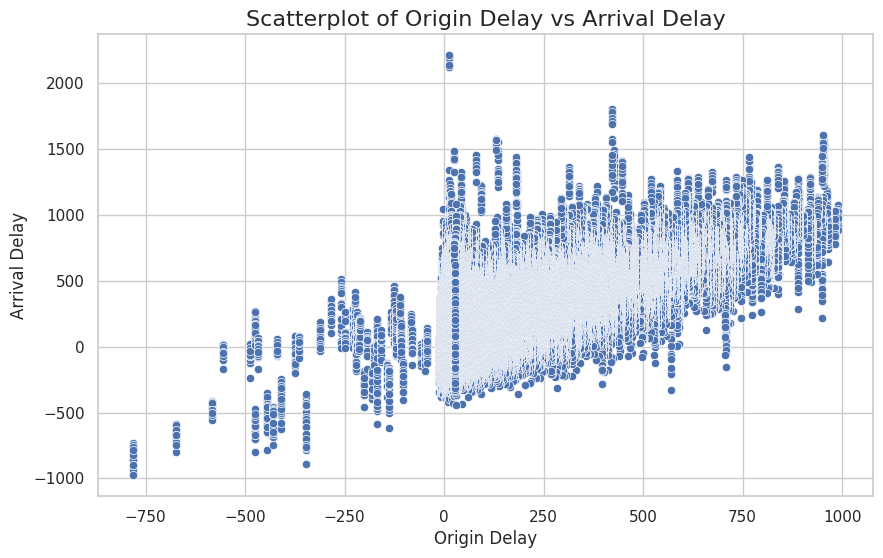

In [ ]:
# scatterplot
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style for the plot
sns.set(style="whitegrid")

# Create a scatterplot of 'origin_delay' vs 'arrival_delay'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='origin_delay', y='arrival_delay', data=df_final)

# Set plot labels and title
plt.title('Scatterplot of Origin Delay vs Arrival Delay', fontsize=16)
plt.xlabel('Origin Delay', fontsize=12)
plt.ylabel('Arrival Delay', fontsize=12)

# Add a red line to show linear relationship between arrival delay and origin delay
# plt.plot([-3200, 3000], [-3200, 3000], color='red', linestyle='--')

# Show the plot
plt.show()

df = df_final

In [ ]:
df = df.drop(['bus_id',
              'route_id',
              'factor(weather)Normal',
              'factor(temperature)Normal',
              'factor(weather)Rain',
              'factor(weather)Snow',
              'factor(weather)Light_Snow',
              'factor(temperature)Cold',
              'factor(temperature)Extra_cold',
              'factor(weather)Light_Rain'],  axis=1)
              #'previous_trip_travel_time',
              #'traffic_condition'

In [ ]:
x = df.drop(['arrival_delay'], axis=1)
y = df['arrival_delay']

<Axes: xlabel='arrival_delay', ylabel='Count'>

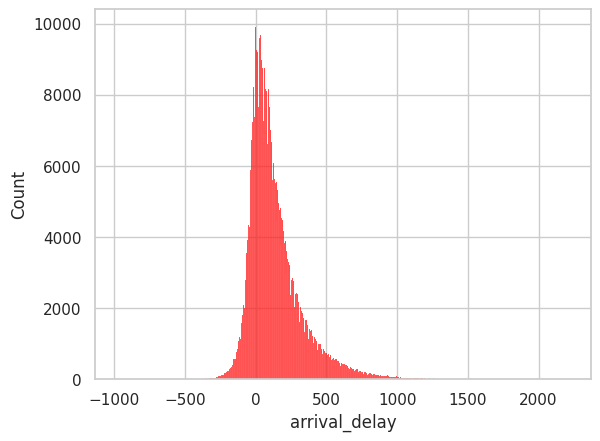

In [ ]:
import seaborn as sns
sns.histplot(x=df['arrival_delay'], color='red')

# XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBRegressor
import xgboost as xgb

In [ ]:
model_XGB = XGBRegressor()

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
#Define hyperparameter grid with random values using RandomizedSearchCV
param_grid = {
    'n_estimators': randint(50, 201),          # Random integers between 50 and 200
    'learning_rate': uniform(0.01, 0.19),      # Random floats between 0.01 and 0.2
    'max_depth': randint(3, 11),               # Random integers between 3 and 10 (tree depth)
    'subsample': uniform(0.6, 0.4),            # Random floats between 0.6 and 1.0 (fraction of data)       #WHAT?
    'colsample_bytree': uniform(0.5, 0.5),     # Random floats between 0.5 and 1.0 (fraction of features)   #WHAT?
    'reg_alpha': uniform(0, 1),                # Random floats between 0 and 1 (L1 regularization)
    'reg_lambda': uniform(1, 2),               # Random floats between 1 and 3 (L2 regularization)
}

#Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_XGB,
    param_distributions=param_grid,
    n_iter=100, #Number of random parameter combinations to try
    cv=5, # Five fold cross-validation
    verbose=1, #How much information do you want in the output window
    random_state=42, #Always use same random state
)

{'n_estimators': 84, <br>
 'learning_rate': 0.12589936497869797,<br>
 'max_depth': 10,<br>
 'subsample': 0.8650089137415928,<br>
 'colsample_bytree': 0.8416317594127292,<br>
 'reg_alpha': 0.9093204020787821,<br>
 'reg_lambda': 1.5175599632000338,
}

In [ ]:
#TRAIN MODEL: Fit RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_train, y_train, verbose=2)

# Print the best hyperparameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best hyperparameters:", best_params, "\nBest model: ", best_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'colsample_bytree': 0.6974407590877849, 'learning_rate': 0.06576275319642724, 'max_depth': 9, 'n_estimators': 188, 'reg_alpha': 0.19884240408880516, 'reg_lambda': 2.4226839054973, 'subsample': 0.9160702162124823} 
Best model:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6974407590877849, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06576275319642724, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=

In [26]:
# saving the xgboost model to use in scenarios
import joblib
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [ ]:
best_params

{'colsample_bytree': 0.6974407590877849,
 'learning_rate': 0.06576275319642724,
 'max_depth': 9,
 'n_estimators': 188,
 'reg_alpha': 0.19884240408880516,
 'reg_lambda': 2.4226839054973,
 'subsample': 0.9160702162124823}

In [ ]:
# Predict the test data with the fitted model
y_pred_XGB = best_model.predict(X_test)

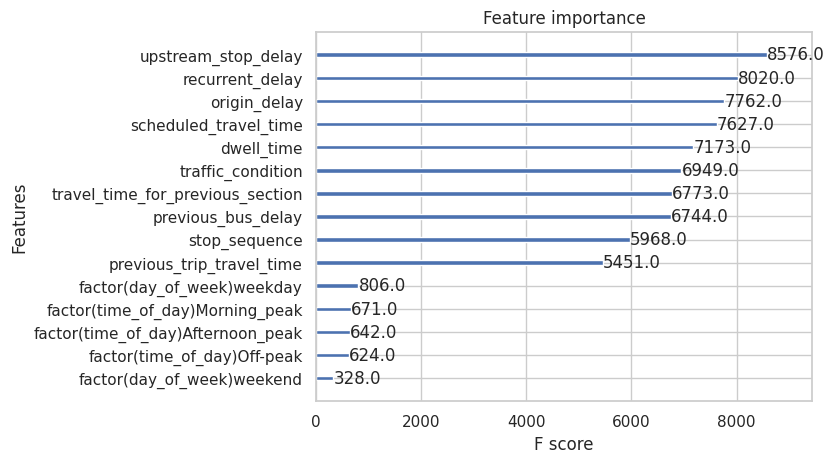

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(best_model, ax=plt.gca())
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
mse_XGB = mean_squared_error(y_test, y_pred_XGB)
r2_XGB = r2_score(y_test, y_pred_XGB)

print(f"Mean Absolute Error: {mae_XGB}")
print(f"Mean Squared Error: {mse_XGB}")
print(f"R-squared: {r2_XGB}")

Mean Absolute Error: 13.040665608126229
Mean Squared Error: 467.20698863603957
R-squared: 0.9868745803833008


In [ ]:
# X_test

# Make predictions with our model

In [ ]:
print(', '.join(map(str, y_pred_XGB)))

-65.04244, 31.529226, 592.5323, 356.5246, 331.5606, 852.43304, 377.08084, 160.21786, 211.05728, 189.1632, 77.14721, 156.98024, -2.9409995, 261.18958, 21.97939, 108.25498, 63.29381, 317.47794, 105.26884, 0.09243499, 323.7569, 173.26846, 24.470936, 5.073423, 139.57562, 92.92864, 302.12985, 37.36564, 36.553497, 44.956783, 152.83728, 212.76634, -5.450593, 52.14225, 119.11519, -11.675199, 515.79095, 84.53793, 210.37756, 536.6033, 108.08471, 174.46223, 164.53226, 61.58833, 206.1584, 171.16092, 399.1123, -79.75932, 29.482264, 75.90662, 290.21533, 121.75294, 162.85306, 248.67014, 181.51938, 80.96654, 379.63275, 40.947163, 179.30765, 621.8241, 888.72906, 487.82065, 46.43456, 67.01749, -14.78504, 3.9111433, 104.42745, 133.5303, 17.275625, 204.57242, 279.73065, 267.30936, 228.84903, 776.47815, -15.908441, -9.004446, -111.55706, 53.38825, 227.6294, -41.009365, 48.11559, 255.75708, -38.741158, 9.417843, 174.68562, 433.16208, 219.45763, 119.888626, 13.9098, 231.60901, 234.26863, 276.62274, 79.95551,

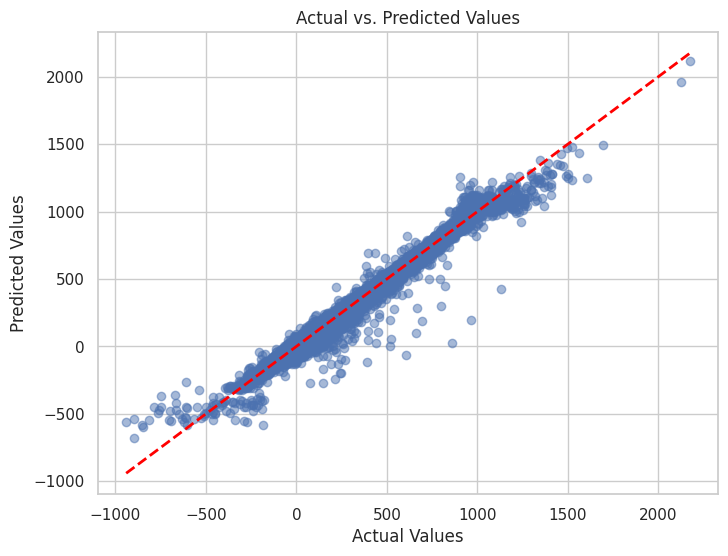

In [ ]:
import matplotlib.pyplot as plt

# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_XGB, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

# Program that asks user about their data and makes a prediction with our model

In [ ]:
Index(['stop_sequence', 'dwell_time', 'travel_time_for_previous_section',
       'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
       'previous_bus_delay', 'recurrent_delay', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'],
      dtype='object')

NameError: name 'Index' is not defined

In [ ]:
# #----------------------**Mapping**-------------------------------------------
# # Dictionary mapping stop names to stop numbers
# stop_mapping = {
#     'skanstull': 1,
#     'eriksdal': 2,
#     'rosenlund': 3,
#     'södrastation': 4,
#     #Three names for the same station
#     'hornsgatan/rosenlundsgatan': 5,
#     'zinkensdamm': 6,
#     'varvsgatan': 7,
#     'hornstull': 8,
#     'högalidsgatan': 9,
#     'västerbroplan': 10,
#     'mariebergsgatan': 11,
#     'fridhemsplan': 12,
#     'flemminggatan': 13,
#     'steriksplan': 14,
#     'dalagatan': 15,
#     'odenplan': 16,
#     'stadsbiblioteket': 17,
#     'roslagsgatan': 18,
#     'vallhallavägen': 19,
#     'östrastation': 20,
#     'stadion': 21,
#     'musikhögskolan': 22,
#     'jungfrugatan': 23,
#     'värtavägen': 24,
#     'banergatan': 25,
#     'garnisonen': 26,
#     'radiohuset': 27
# }

# # Function to get stop number from user input (either a number or a name)
# def get_stop_number(prompt):
#     user_input = input(prompt).strip().lower().replace(" ", "")  # Strip whitespace and make input lowercase

#     # Check if the input is numeric and within the valid range (1-27)
#     # This will return the number as an integer
#     if user_input.isdigit() and 1 <= int(user_input) <= 27:
#         return int(user_input)

#     # Check if the input is a valid stop name
#     elif user_input in stop_mapping:
#         return stop_mapping[user_input]

#     # If invalid, notify the user and ask again
#     else:
#         print("Invalid stop. Please enter a valid stop number (1-27) or stop name. Examples: Södra station, hornstull, steriksgatan")
#         return get_stop_number(prompt)  # Recursively call until valid input
# #----------------------**Mapping**-------------------------------------------

# #----------------------**Functions to get time**-------------------------------------------
# def get_time_factors():
#     # Prompt for weekday/weekend
#     time_of_week = input("Is it a weekday or weekend? (Enter 'weekday' or 'weekend'): ").strip().lower()

#     if time_of_week == 'weekday':
#         weekday = 1
#         weekend = 0
#     elif time_of_week == 'weekend':
#         weekday = 0
#         weekend = 1
#     else:
#         print("Invalid input. Please enter 'weekday' or 'weekend'.")
#         return get_time_factors()

#     # Prompt for time of day
#     time_of_day = get_time_of_day()
#     morning_peak, afternoon_peak, off_peak = time_of_day

#     # if time_of_day == 'morning':
#     #     morning_peak = 1
#     #     afternoon_peak = 0
#     #     off_peak = 0
#     # elif time_of_day == 'afternoon':
#     #     morning_peak = 0
#     #     afternoon_peak = 1
#     #     off_peak = 0
#     # elif time_of_day == 'off-peak':
#     #     morning_peak = 0
#     #     afternoon_peak = 0
#     #     off_peak = 1
#     # else:
#     #     raise ValueError("Invalid input. Please enter 'morning', 'afternoon', or 'off-peak'.")

#     return {
#         'factor(day_of_week)weekday': weekday,
#         'factor(day_of_week)weekend': weekend,
#         'factor(time_of_day)Afternoon_peak': afternoon_peak,
#         'factor(time_of_day)Morning_peak': morning_peak,
#         'factor(time_of_day)Off-peak': off_peak
#     }

# def get_time_of_day():
#     time_of_day = input("Is it Morning peak, Afternoon peak, or Off-peak? (Enter 'morning', 'afternoon', or 'off-peak'): ").strip().lower()

#     if time_of_day == 'morning':
#         morning_peak = 1
#         afternoon_peak = 0
#         off_peak = 0
#     elif time_of_day == 'afternoon':
#         morning_peak = 0
#         afternoon_peak = 1
#         off_peak = 0
#     elif time_of_day == 'off-peak':
#         morning_peak = 0
#         afternoon_peak = 0
#         off_peak = 1
#     else:
#         print("Invalid input. Please enter 'morning', 'afternoon', or 'off-peak'.")
#         return get_time_of_day()

#     return morning_peak, afternoon_peak, off_peak
# #----------------------**Functions to get time**-------------------------------------------

# #----------------------**Get user info**-------------------------------------------
# def get_user_input():
#     get_off_stop = get_stop_number("Enter stop you're going to (1-27 or stop name). For example '1' or 'Östra station' ")
#     # Collect input for the first 13 features
#     user_data = {
#         'stop_sequence': get_stop_number("Enter stop you're at (1-27 or stop name). For example '1' or 'Östra station' "),
#         'dwell_time': int(input("Enter dwell_time (in seconds): ")),
#         'travel_time_for_previous_section': int(input("Enter travel_time_for_previous_section (in seconds): ")),
#         'scheduled_travel_time': int(input("Enter scheduled_travel_time (in seconds): ")),
#         'upstream_stop_delay': int(input("Enter upstream_stop_delay (in seconds): ")),
#         'origin_delay': int(input("Enter origin_delay (in seconds): ")),
#         'previous_bus_delay': int(input("Enter previous_bus_delay (in seconds): ")),
#         'recurrent_delay': float(input("Enter recurrent_delay (in seconds): ")),
#         'previous_trip_travel_time' :float(input("Enter previous_trip_travel_time (in seconds): ")),
#         'traffic_condition' :float(input("Enter traffic_condition (in seconds): ")),
#     }

#     time_factors = get_time_factors()
#     user_data.update(time_factors)

#     return user_data, get_off_stop

# # # Getting input from user
# input_data, get_off_stop = get_user_input()
# print(input_data)
# input_df = pd.DataFrame([input_data])
# #----------------------**Get user info**-------------------------------------------


# # # Use the trained model (best_model) to make a prediction
# model = load_model(filepath)
# prediction_start_station = model.predict(input_df)

# input_df.loc[0, 'stop_sequence'] = get_off_stop
# prediction_end_station = model.predict(input_df)

# # # Output the prediction
# print(f"Predicted arrival_delay at your station: {prediction_start_station[0]}")
# print(f"Predicted arrival_delay at your destination: {prediction_end_station[0]}")